# Fiber Learning Model Demo

This notebook demonstrates fiber learning with generative models on small FIFs trained on EMNIST.<br>
First we train a subject model from which we want to learn the fibers from.<br>
Next we train a dimensions reducing VAE that should be lossless and provide a more dense latent space in which the fiber learning model is operating.<br>
Lastly we train the fiber learning model on the resulting representations of the subject model in the latent space of the VAE.

In [19]:
import os
os.chdir(os.path.expanduser('~/PhD/FFF_fiberlearning/'))
import fff
import yaml
import lightning_trainable
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
from pathlib import Path
matplotlib.rcParams.update({'font.size': 18})
import gc         # garbage collect library
import shutil
from fff.evaluate.eval_mnist_fibers import *

In [2]:
save = False
plot_dir = "demo"
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)

In [3]:
def plot_images_16(data, title, model, n_rows=2, n_columns=9, save=False, plot_dir="demo"):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(2*n_columns, 2*n_rows))
    for i in range(n_rows):
        for j in range(n_columns):
            axes[i][j].imshow(data[i*n_columns +j].cpu().reshape(16, 16).T, cmap='gray', vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle(title)
    if save:
        plt.savefig(f"plots/{plot_dir}/{model}/{title}.png", bbox_inches='tight')

## Subject Model

First we train a small FIF with 5-dimensional bottleneck on the digit split of EMNIST.

In [4]:
hparams_sm_five = fff.fif.FreeFormInjectiveFlowHParams(
    noise= 0.05,
    data_set= {"name": "mnist_ds", "root": "data", "conditional": False},
    loss_weights= {"noisy_reconstruction": 100, "z_reconstruction_encoder": 10, "nll": 1},
    train_models= True,
    models= [{
        "name": "fff.model.ConvolutionalNeuralNetwork",
        "latent_dim": 100,
        "ch_factor": 32,
        "encoder_spec": [
            [2,4,2,1],
            [4,4,2,1],
            [8,4,2,1]],
        "decoder_spec": [
            [8,4],
            [4,4,2,1],
            [1,3,2,1,1]
        ]},
        {"name": "fff.model.ResNet",
         "latent_dim": 5,
         "dropout": 0.5,
         "layers_spec": [
             [32,32],
             [32,32]]}
    ],
    optimizer= {
        "name": "adam",
        "lr": 0.0005,
        "weight_decay": 0.01,
    },
    max_epochs= 22,
    batch_size= 512)

In [5]:
subject_model = fff.fif.FreeFormInjectiveFlow(hparams_sm_five)

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  5


In [6]:
subject_model.fit(logger_kwargs=dict(name="fif_5d", save_dir="subject_models"))

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
2024-11-18 13:05:27.429535: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 13:05:27.460818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=22` reached.
INFO: `Trainer.fit` stopped: `max_epochs=22` reached.


{'training/z 1D-Wasserstein-1': 0.12074880301952362,
 'training/z std': 0.8098803162574768,
 'training/loss': 234.887451171875,
 'training/nll': 1.2796332836151123,
 'training/reconstruction': 2.167001485824585,
 'training/noisy_reconstruction': 2.3270161151885986,
 'training/sqr_reconstruction': 6.100991725921631,
 'training/z_reconstruction_encoder': 0.09062161296606064,
 'validation/z 1D-Wasserstein-1': 0.1672889143228531,
 'validation/z std': 0.18497098982334137,
 'validation/loss': 259.7740783691406,
 'validation/nll': 14.22907829284668,
 'validation/vol_change_encoder': -4.354639053344727,
 'validation/vol_change_decoder': -7.993612289428711,
 'validation/nll_encoder': 10.590104103088379,
 'validation/nll_decoder': 14.22907829284668,
 'validation/reconstruction': 2.2951912879943848,
 'validation/noisy_reconstruction': 2.4453163146972656,
 'validation/sqr_reconstruction': 6.64643669128418,
 'validation/masked_reconstruction': 5.566534519195557,
 'validation/z_reconstruction_encode

In [6]:
sm_path = "subject_models/fif_5d/version_0" # Check at which version the subject_model is saved!!!!

In [7]:
#If already trained:
subject_model = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(sm_path + "/checkpoints/last.ckpt")

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  5


In [8]:
torch.set_grad_enabled(False)

In [9]:
def save_and_plot_data(rectangular_flow, name):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    print("save data...")
    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    
    Path(f"data/{name}/subject_model").mkdir(parents=True, exist_ok=True)
    fileName = f"data/{name}/data"
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    shutil.copytree(sm_path, f"data/{name}/subject_model", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)

    print("evaluate model...")
    print("reconstructing...")
    reconstruction1 = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c_test.split(batch_size))
    ])
   
    print("sampling...")
    z_sampled = torch.randn_like(z_test)
    x_sampled = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), c_test.split(batch_size))
    ])
    plot_images_16(test_samples, "Original", "subject_model")
    plot_images_16(reconstruction1, "Reconstruction", "subject_model")
    plot_images_16(x_sampled, "Samples", "subject_model")
    return data["test_y"]

encoding traindata...
encoding valdata...
encoding testdata...
save data...
evaluate model...
reconstructing...
sampling...


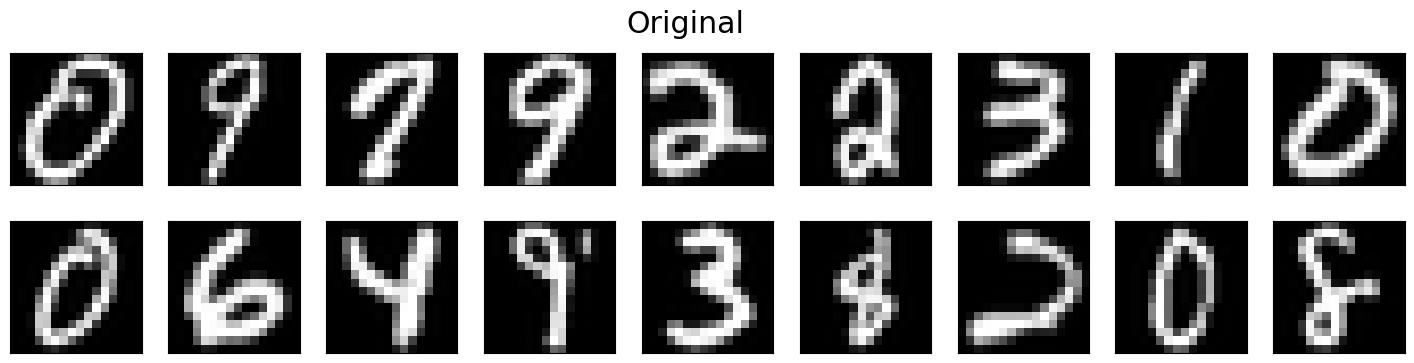

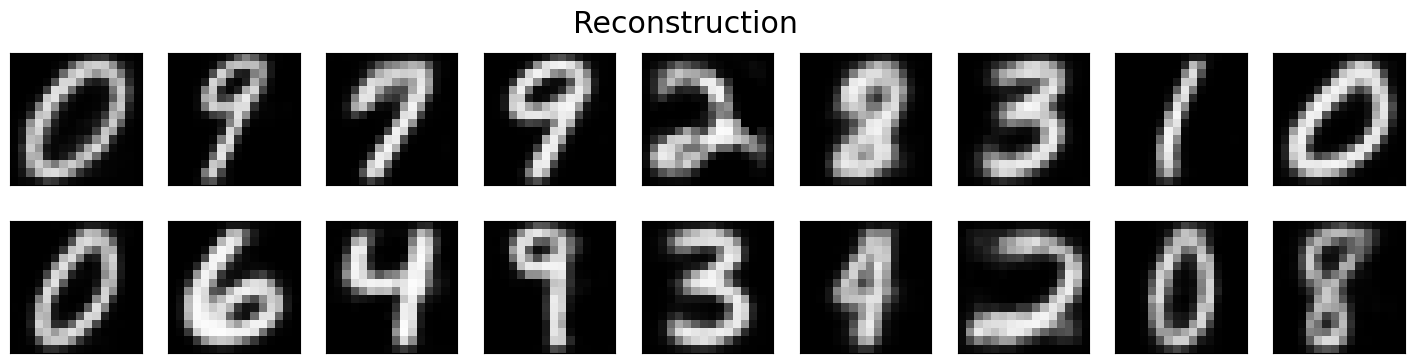

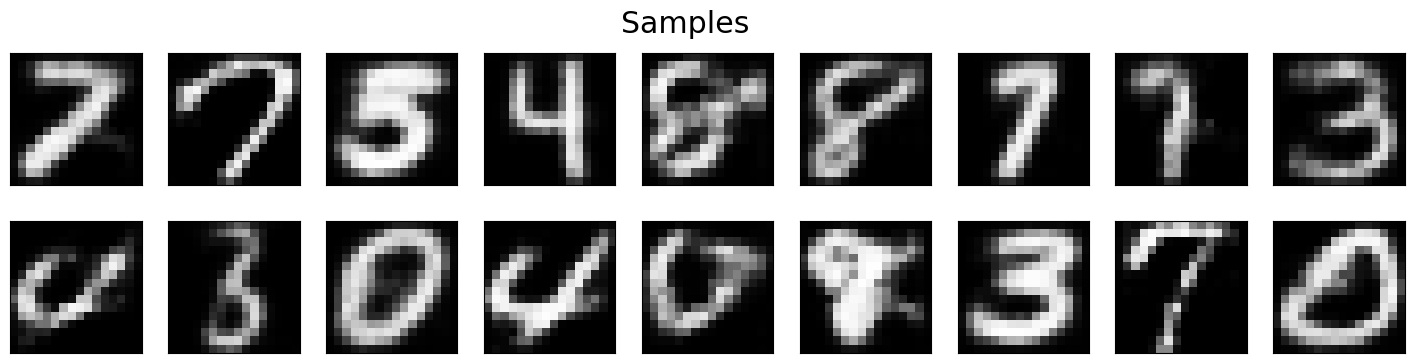

In [10]:
test_data_representation = save_and_plot_data(subject_model, name="16EMNIST_F5F_demo")

In [11]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_data_representation)

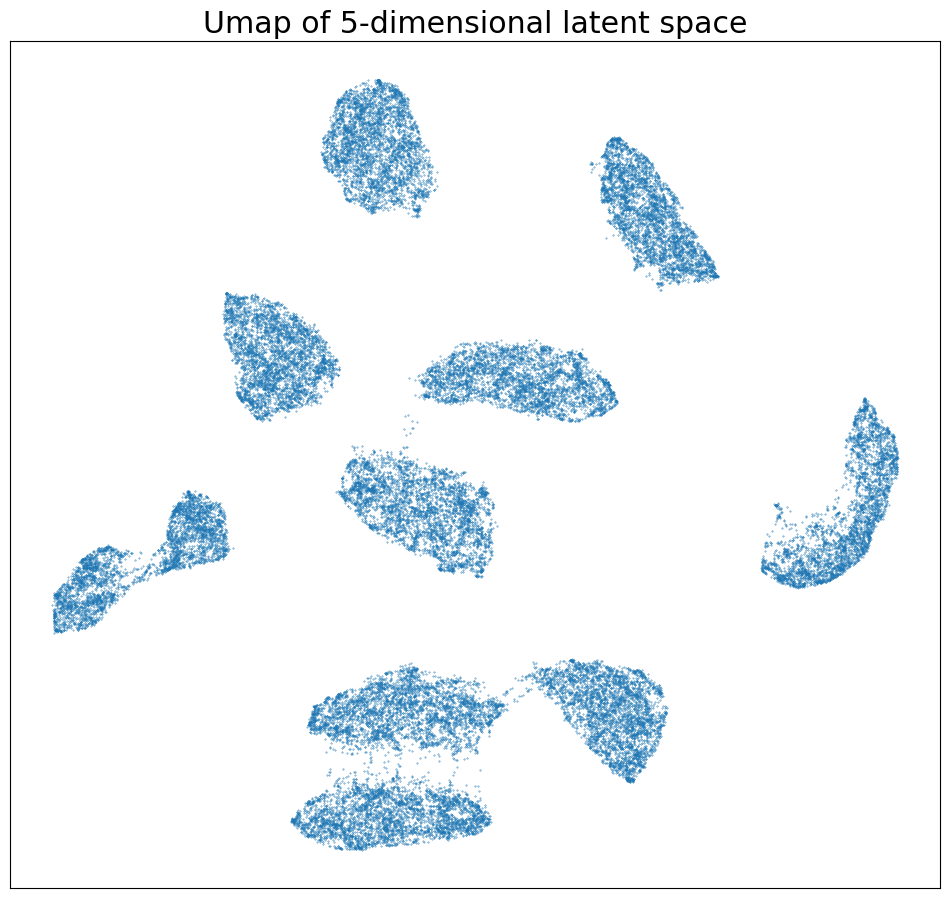

In [12]:
plt.figure(figsize=[12,11])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=0.1
)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title("Umap of 5-dimensional latent space")
if save:
    plt.savefig(f"plots/{plot_dir}/subject_model/UMAP.png", bbox_inches='tight')

## Train Lossless VAE for the latent space

In [13]:
hparams_vae = fff.fif.FreeFormInjectiveFlowHParams(
    vae = True,
    eval_all = False,
    noise = 0.01,
    data_set = {"name": "mnist_ds", "root": "data", "conditional": False},
    loss_weights = {"kl": 1, "noisy_reconstruction": 1000},
    train_models = True,
    models = [{
        "name": "fff.model.ConvolutionalNeuralNetwork",
        "latent_dim": 100,
        "ch_factor": 32,
        "encoder_spec": [
            [2,4,2,1],
            [4,4,2,1],
            [8,4,2,1]],
        "decoder_spec": [
            [8,4],
            [4,4,2,1],
            [1,3,2,1,1]
        ]},
        {"name": "fff.model.VarResNet",
         "latent_dim": 64,
         "layers_spec": [
             [512,512],
             [512,512]]}
    ],
    optimizer = {
        "name": "Adam",
        "lr": 0.0005,
        "weight_decay": 0.01,
    },
    max_epochs = 650,
    batch_size = 512)

In [14]:
VAE = fff.fif.FreeFormInjectiveFlow(hparams_vae)

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  64


In [15]:
torch.set_grad_enabled(True)
VAE.fit(logger_kwargs=dict(name="vae", save_dir="lossless_ae"))

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type       | Params
--------------------------------------
0 | models | Sequential | 3.2 M 
--------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimate

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=650` reached.
INFO: `Trainer.fit` stopped: `max_epochs=650` reached.


{'training/z 1D-Wasserstein-1': 0.059161171317100525,
 'training/z std': 1.0871766805648804,
 'training/loss': -1101.0965576171875,
 'training/kl': 243.4717559814453,
 'training/reconstruction': -1.5081841945648193,
 'training/noisy_reconstruction': -1.3445684909820557,
 'training/sqr_reconstruction': 0.0957975909113884,
 'validation/z 1D-Wasserstein-1': 0.05756393447518349,
 'validation/z std': 1.0945342779159546,
 'validation/loss': -778.46044921875,
 'validation/kl': 244.16624450683594,
 'validation/reconstruction': -1.1821496486663818,
 'validation/noisy_reconstruction': -1.0226267576217651,
 'validation/sqr_reconstruction': 0.1279737502336502}

In [16]:
checkpoint = lightning_trainable.utils.find_checkpoint(root="lossless_ae/vae", version=0, epoch="last")
VAE = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(checkpoint)

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  64


In [17]:
def eval_vae(model2plt):
    device = model2plt.device
    
    data = {}
    true_test_batch = model2plt.test_data[:]
    test_conditioned = model2plt.apply_conditions(true_test_batch)
    true_test_c = test_conditioned.condition
    true_test_samples = test_conditioned.x_noisy
    
    print("encoding...")
    batch_size = model2plt.hparams.batch_size
    true_test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(true_test_samples.split(batch_size), true_test_c.split(batch_size))
    ])
    
    print("reconstructing...")
    true_reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(true_test_z.split(batch_size), true_test_c.split(batch_size))
    ])

    print("sampling...")
    z_sampled = torch.randn_like(true_test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), true_test_c.split(batch_size))
    ])
    
    #plotting...
    plot_images_16(true_test_samples, "Original", "vae")
    plot_images_16(true_reconstruction, "Reconstruction", "vae")
    plot_images_16(x_sampled, "Sampled", "vae")

encoding...
reconstructing...
sampling...


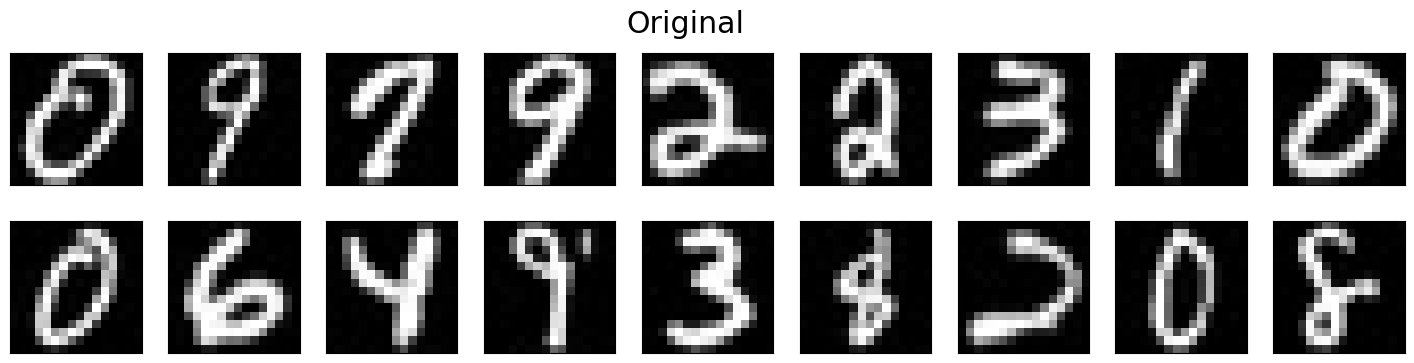

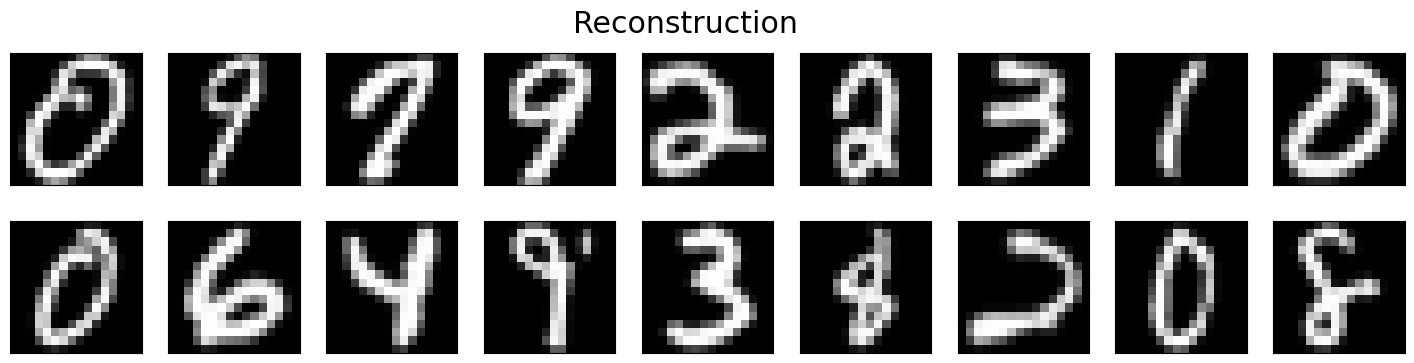

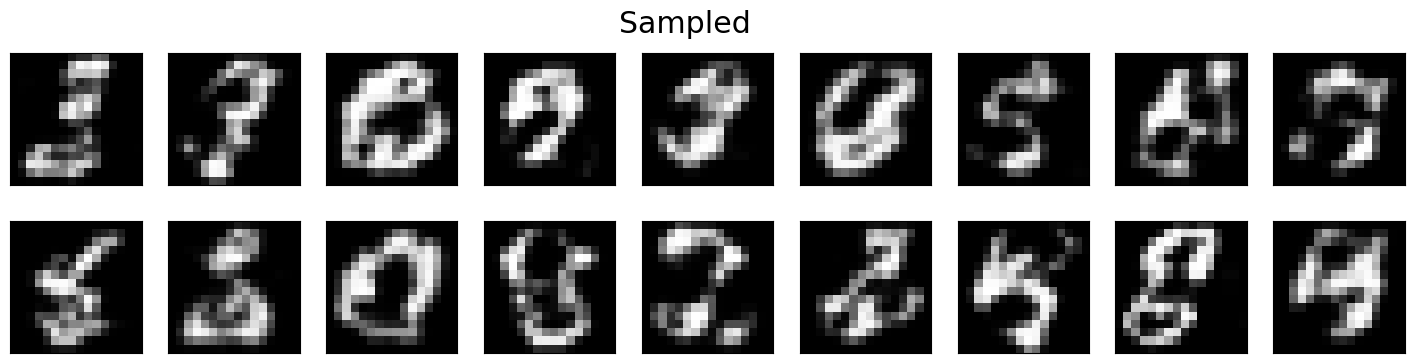

In [18]:
torch.set_grad_enabled(False)
eval_vae(VAE)

## Train fiber-learning model

In [20]:
data_name = "16EMNIST_F5F_demo"

In [21]:
hparams_fl_fif = fff.fif.FreeFormInjectiveFlowHParams(
    vae = True,
    noise = 0.01,
    latent_distribution = {"name": "transformed_normal"},
    data_set = {"name": "mnist_split", "root": "data", "conditional": True, "path": data_name},
    loss_weights = {"nll": 1, "latent_reconstruction": 10, "masked_reconstruction": 1, "fiber_loss": 10},
    train_models = False,
    train_transform = True,
    models = [{
        "name": "fff.model.ConvolutionalNeuralNetwork",
        "latent_dim": 100,
        "ch_factor": 32,
        "encoder_spec": [
            [2,4,2,1],
            [4,4,2,1],
            [8,4,2,1]],
        "decoder_spec": [
            [8,4],
            [4,4,2,1],
            [1,3,2,1,1]
        ]},
        {"name": "fff.model.VarResNet",
         "latent_dim": 64,
         "layers_spec": [
             [512,512],
             [512,512]]}
    ],
    load_models_path = "lossless_ae/vae/version_0/checkpoints/last.ckpt",
    transform = {
        "name": "fff.model.ResNet",
        "data_dim": 64,
        "latent_dim": 64-5,
        "layers_spec": [
            [512, 512],
            [512, 512],
            [512, 512]]},
    optimizer = {
        "name": "adam",
        "lr": 0.002,
    },
    lr_scheduler = "onecyclelr",
    max_epochs = 200,
    batch_size = 512,
    load_subject_model = True)

In [22]:
model = fff.fif.FreeFormInjectiveFlow(hparams_fl_fif)

torch.Size([5000, 256])
cond_dim:  0
latent_dim:  64
load models checkpoint
Only the transform_model will be trained while the model is kept fixed!
Also the noise is added only to the latent variables!
cond_dim:  5
latent_dim:  59
loading subject_model
torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  5


In [23]:
torch.set_grad_enabled(True)
model.fit(logger_kwargs=dict(name="fif", save_dir="lightning_logs"))

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type                  | Params
----------------------------------------------------------
0 | models          | Sequential            | 3.2 M 
1 | transform_model | ResNet                | 2.0 M 
2 | subject_model   | FreeFormI

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO: `Trainer.fit` stopped: `max_epochs=200` reached.


{'training/z 1D-Wasserstein-1': 0.020316658541560173,
 'training/z std': 1.0073455572128296,
 'training/loss': 34.74718475341797,
 'training/nll': 23.70667839050293,
 'training/latent_reconstruction': 0.8613382577896118,
 'training/masked_reconstruction': 1.9158865213394165,
 'training/fiber_loss': 0.05112367123365402,
 'training/z_sample_reconstruction': 1.5394402742385864,
 'validation/z 1D-Wasserstein-1': 0.037641171365976334,
 'validation/z std': 0.05302118510007858,
 'validation/loss': 44.81514358520508,
 'validation/nll': 30.17405891418457,
 'validation/vol_change_encoder': 45.599979400634766,
 'validation/vol_change_decoder': 56.52048873901367,
 'validation/nll_encoder': 41.09456253051758,
 'validation/nll_decoder': 30.17405891418457,
 'validation/latent_reconstruction': 1.2082271575927734,
 'validation/reconstruction': 0.3030749559402466,
 'validation/noisy_reconstruction': 0.3030749559402466,
 'validation/sqr_reconstruction': 0.10523141920566559,
 'validation/masked_reconstruc

## Evaluate fiber-learning model

In [24]:
#If you want to load a trained model
#checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/fif", version=0, epoch="last")
#model = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(checkpoint)

In [25]:
subject_model = model.subject_model

In [26]:
def evaluate_model(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    test_batch = model2plt.test_data[:]

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x_noisy
    train_c = train_conditioned.condition
    train_c0 = torch.empty((train_samples.shape[0], 0), device=train_samples.device, dtype=train_samples.dtype)
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x0
    test_c0 = torch.empty((test_samples.shape[0], 0), device=test_samples.device, dtype=test_samples.dtype)
    
    data["train_samples"] = train_samples
    data["test_samples"] = test_samples
    data["test_c"] = test_c
    data["train_c"] = train_c
    
    print("sampling...")
    x_sampled = model2plt.sample((test_samples[:].shape[0],),test_c[:].to(device))
    
    c_sm = torch.empty((test_c.shape[0], 0), device=test_c.device)
    conditioned = subject_model.apply_conditions((x_sampled,))
    c_sm = conditioned.condition
    x_sm = conditioned.x0
    xc = subject_model.encode(x_sm.to(subject_model.device), c_sm.to(subject_model.device))
    xc = (xc.detach().cpu() - model.data_shift) / model.data_scale
    latent_dim = xc[0].shape[0]
    delta_coarse = torch.sqrt(torch.sum((xc-test_c[:])**2, dim=1)/latent_dim)
    print("median fiber deviation on test set: ", torch.median(delta_coarse))
    
    return data

In [27]:
torch.set_grad_enabled(False)
data = evaluate_model(model)
if model.transform == "diffusion":
    z_dim = 64
    std_z0 = 1
else:
    z_dim = 64-5
    std_z0 = 1
latent_dim = max(1, data["test_c"].shape[1])

sampling...
median fiber deviation on test set:  tensor(0.0452)


In [28]:
def plot_details(model2plot, data, i_sample, zrange, GD_steps=100, sanity=False):
    device = model2plot.device
    
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    test_samples = data["test_samples"]
    N = 21
    n = 7
    ddim = z_dim
    x_orig = test_samples[i_sample]

    # calculate x_c_x for train_data
    conditioned = subject_model.apply_conditions((train_samples,))
    c_sm = conditioned.condition
    x_sm = conditioned.x0
    y_sm = torch.cat([
        subject_model.encode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(x_sm.split(512), c_sm.split(512))
    ])
    train_c_sm = (y_sm  - model2plot.data_shift) / model2plot.data_scale
    # calculate x_c_x for test_data
    conditioned = subject_model.apply_conditions((test_samples,))
    c_sm = conditioned.condition
    x_sm = conditioned.x0
    y_sm = torch.cat([
        subject_model.encode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(x_sm.split(512), c_sm.split(512))
    ])
    x_test_sm = subject_model.decode(y_sm.to(device), c_sm.to(subject_model.device)).detach().cpu()
    xcx = x_test_sm[i_sample]
    c_sm = (y_sm  - model2plot.data_shift) / model2plot.data_scale

    # calculate Nearest Neighbours
    verify = c_sm[i_sample]
    NN, similar, NN_suptitle, NN_titles = calc_NNs(latent_dim, verify, train_c_sm, train_samples, n+1)
    
    #calculate walk along 0th detail dimension with sampled rest
    z0_range = torch.linspace(pos_min, pos_max, N)
    #z0_sample = z[i_sample][0].numpy()

    #new_details_norm = torch.randn(40,N,ddim-1)
    new_details_norm = model2plot.get_latent("cpu").Dist.sample([40,N])[:,:,:-1]
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,ddim))
    vz_dense = new_details_norm
    #print(torch.reshape(new_details_norm, (40,N,100))[0,:,0])
    
    #decoding...
    c_sample_sm = torch.unsqueeze(c_sm[i_sample], dim=0)
    c_sample = torch.unsqueeze(c[i_sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample_norm0 = torch.empty((c_sample_norm.shape[0], 0), dtype=c_sample.dtype)
    c_sample = c_sample_sm.repeat(N,1)

    if model2plot.transform == "diffusion":
        vz = model2plot.get_latent(device).sample((40*N,), c_sample_norm.to(device)).detach().cpu()
    else:
        vz = model2plot.transform_model.decode(new_details_norm.to(device), c_sample_norm.to(device)).detach().cpu()
    #vz = model2plot.get_latent(device).sample((40*N,), c_sample_norm.to(device)).detach().cpu()
    #vz = torch.randn_like(vz)
    if sanity==True:
        z_orig = model2plot.encode(test_samples[i_sample].to(device), torch.empty(0).to(device))[0].cpu()
        z_orig = z_orig + torch.randn_like(z_orig) * 0.01
        z_orig_rep = z_orig.repeat([40,1])
        vz = vz.reshape([40,N,-1])
        vz[0,1,:] = z_orig
        vz = vz.reshape([40*N,-1])
    vx = model2plot.decode(vz.to(device), c_sample_norm0.to(device)).detach().cpu()
    
    #plotting...
    D_plt_F = {"ind": i_sample, "mark_first": r"original $x$", "mark_second": sanity, "n": n+1, "save_name": "0v_x"}
    i_plot = np.arange(n) * N//n + 1
    D_plt_F["x_plot"] = torch.cat((x_orig.unsqueeze(0), vx[i_plot].detach().cpu()), dim=0)
    #D_plt_F["title_plot = torch.cat((torch.Tensor([z0_sample.item()]), (new_details_norm[i_plot,0]/std_z0)), dim=0)
    D_plt_F["suptitle"] = r"Learned fiber samples $\quad D(t^\dagger(v))$"
    D_plt_F["titles"] = [0,0,1,2,3,4,5,6,7,8,9]

    # calculate sms reconstructions
    vxc, D_plt_sm = plot_sm(model2plot, i_sample, vx, xcx, i_plot, n)
    D_plt_sm["mark_second"] = sanity

    res_pgd = None
    if GD_steps>0:
        # calc PGD and plot PGD
        vxpx, res_pgd, D_plt_PGD, D_plt_PGD_res = plot_PGD(model2plot, latent_dim, i_sample, vz[i_plot], vx[i_plot], x_orig, c_sample_sm[0], n+1, GD_steps)
        D_plt_PGD["mark_second"] = sanity
        D_plt_PGD_res["mark_second"] = sanity
        # plot sm(x_PGD)
        _, D_plt_Psm = plot_sm(model2plot, i_sample, vxpx, xcx, range(n), n, name="PGD")
        D_plt_Psm["mark_second"] = sanity

    # plot check fiber
    title_fiber = f"{nums[i_sample]}-fiber deviation"
    plot_fiber_check(zrange, latent_dim, vxc, c_sample, NN, title_fiber, i_plot, res_pgd, N)

    paths = []
    paths.append(plot_images(**D_plt_F))
    paths.append(plot_images(**D_plt_sm))
    if GD_steps>0:
        paths.append(plot_images(**D_plt_PGD))
        paths.append(plot_images(**D_plt_PGD_res))
        paths.append(plot_images(**D_plt_Psm))

    # plot NNs
    NN_plot = torch.cat((x_orig.unsqueeze(0), similar), dim=0)
    paths.append(plot_images(i_sample, NN_plot, titles=NN_titles, suptitle=NN_suptitle, n=n+1, save_name="4NNs", mark_first= r"original $x$"))
    _, D_plt_NN = plot_sm(model2plot, i_sample, similar, xcx, range(n), n, name="NNs")
    paths.append(plot_images(**D_plt_NN))
    # calculate NNs of fiber samples
    paths_NNs = []
    for i in range(7):
        _, nns, NN_suptitle_i, NN_titles_i = calc_NNs(latent_dim, vxc[i_plot][i], train_c_sm, train_samples, n+1)
        NN_plot_i = torch.cat((vx[i_plot][i].detach().cpu().unsqueeze(0), nns), dim=0)
        paths_NNs.append(plot_images(i_sample, NN_plot_i, titles=NN_titles_i, suptitle=f"NNs of fiber sample {i}", n=n+1, save_name=f"6NNs{i}", mark_first= "fiber sample"))
    if save:
        out_path = f"plots/{plot_dir}/{nums[j]}_stacked.png"
        stack_images_vertically(paths, out_path)
        out_path_NN = f"plots/{plot_dir}/{nums[j]}_stackedNNs.png"
        stack_images_vertically(paths_NNs, out_path_NN)

In [29]:
def plot_images(ind, x_plot, n=8, titles=None, suptitle=None, mark_first=False, mark_second=False, save_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(15, 3))
    for i in range(n):
        axes[i].imshow(x_plot[i].detach().cpu().reshape(16, 16).T, cmap='gray', vmin=0, vmax=1)
        axes[i].xaxis.set_tick_params(labelbottom=False)
        axes[i].yaxis.set_tick_params(labelleft=False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if isinstance(titles, np.ndarray):
            axes[i].set_title(titles[i])
        elif isinstance(titles, tuple) and i>0:
            axes[i].set_title(f"label: {titles[0][i]}")
            axes[i].set_xlabel(f"dist: {titles[1][i]:.2f}")
        elif titles != None:
            axes[i].set_title(titles[i])
    if mark_first:
        for spine in axes[0].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
        axes[0].set_title(mark_first)
    if mark_second:
        for spine in axes[1].spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
        axes[1].set_xlabel(r"VAE($x$)")
    if suptitle != None:
        fig.suptitle(suptitle)
    fig.tight_layout()
    path = f"plots/{plot_dir}/{nums[ind]}_{save_name}.png"
    if save:
        plt.savefig(path, bbox_inches='tight')
        #plt.close()
    return path

tensor(0.3783)


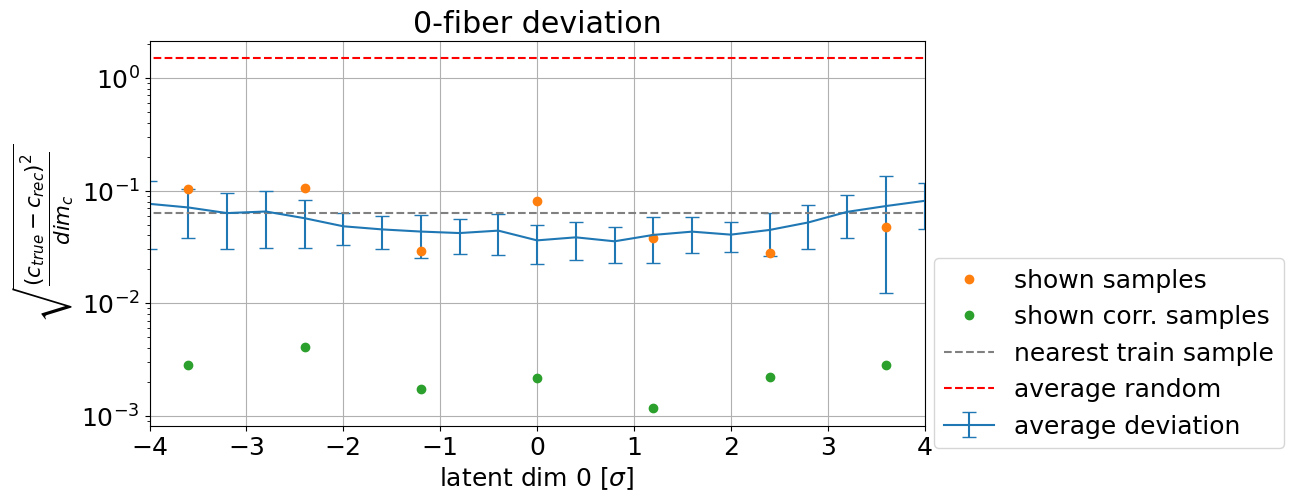

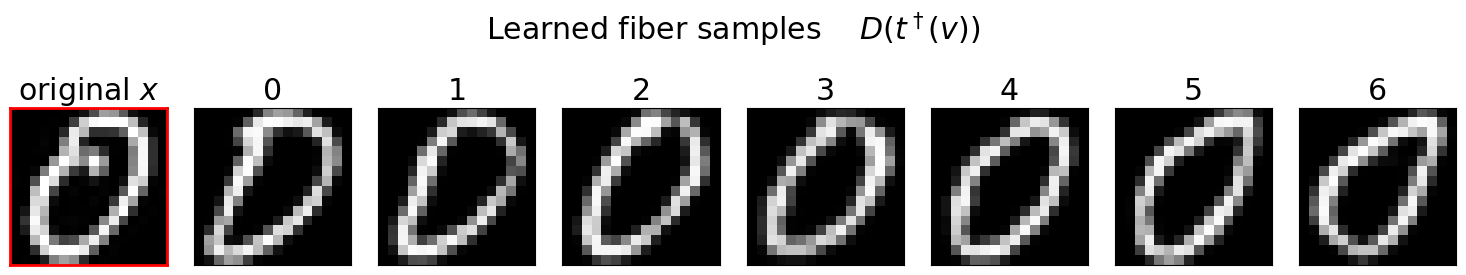

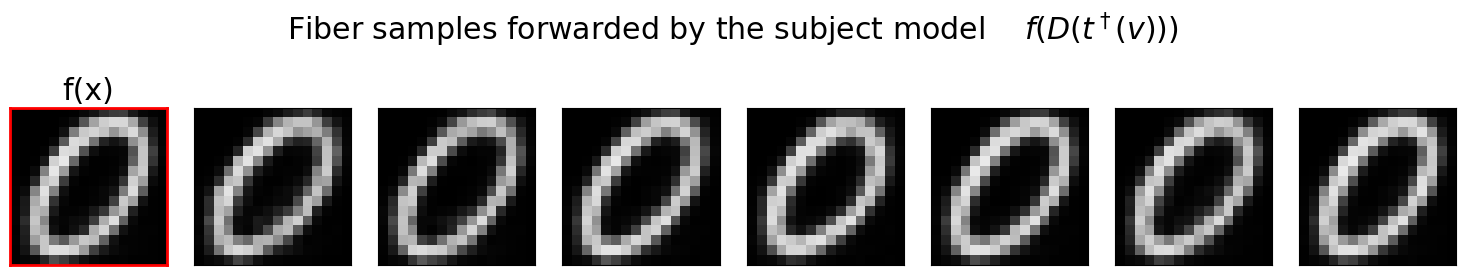

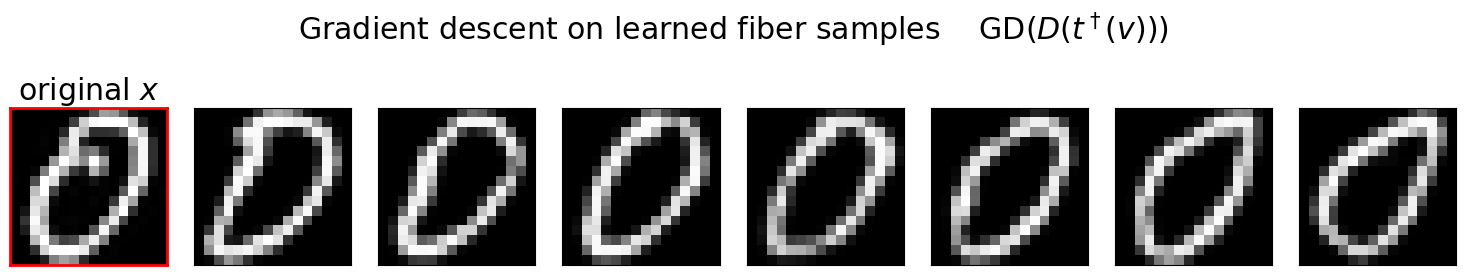

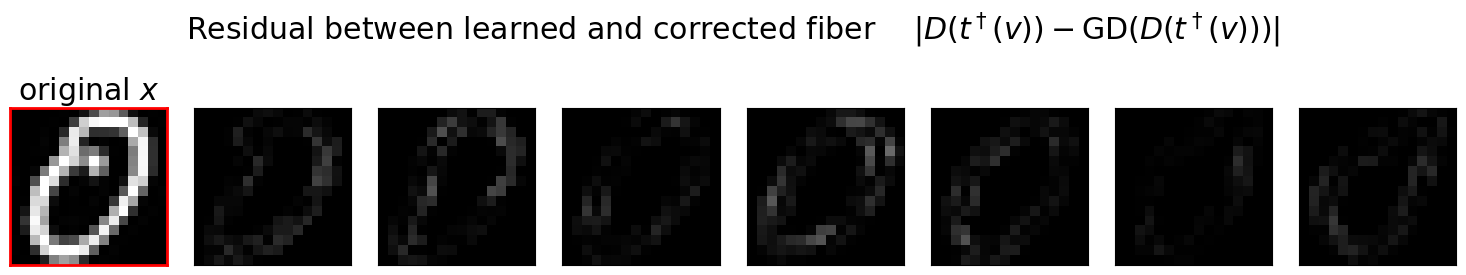

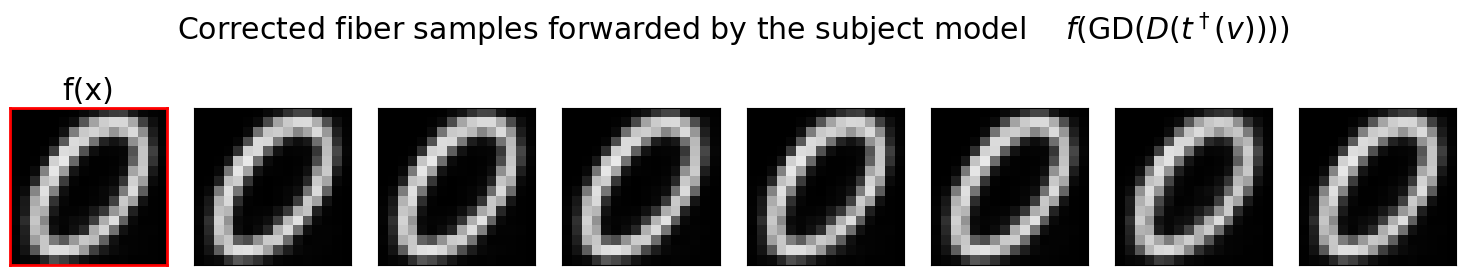

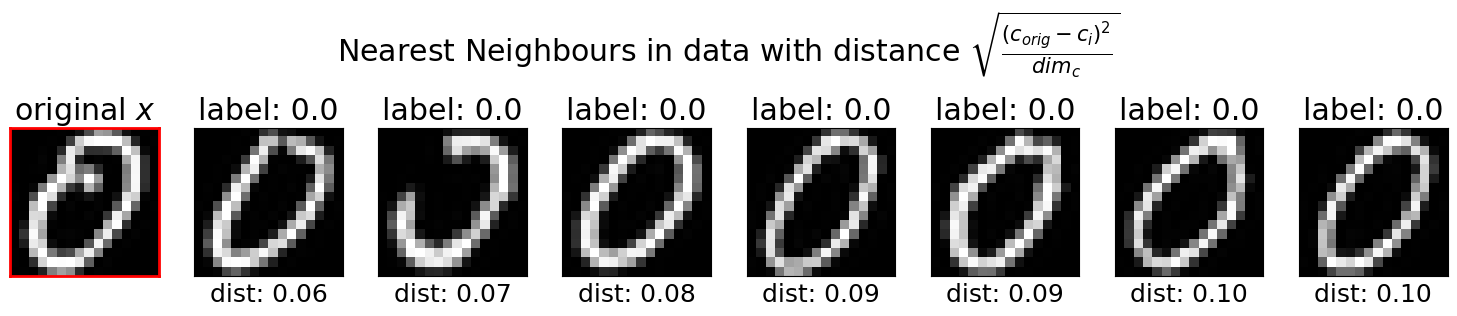

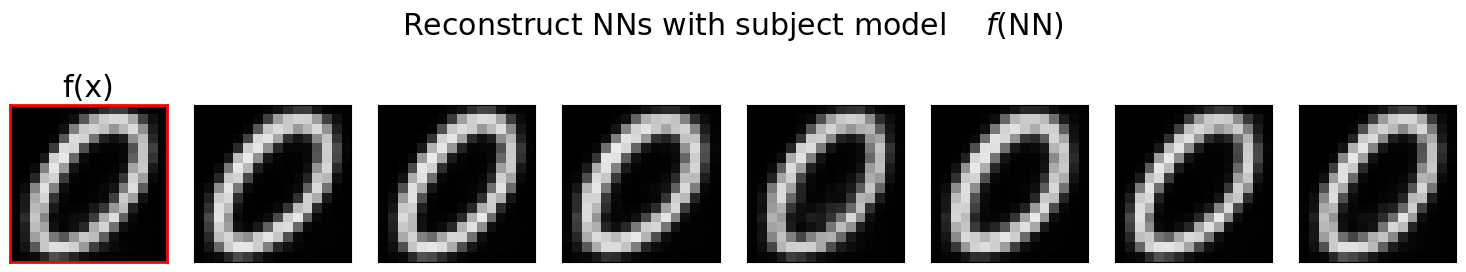

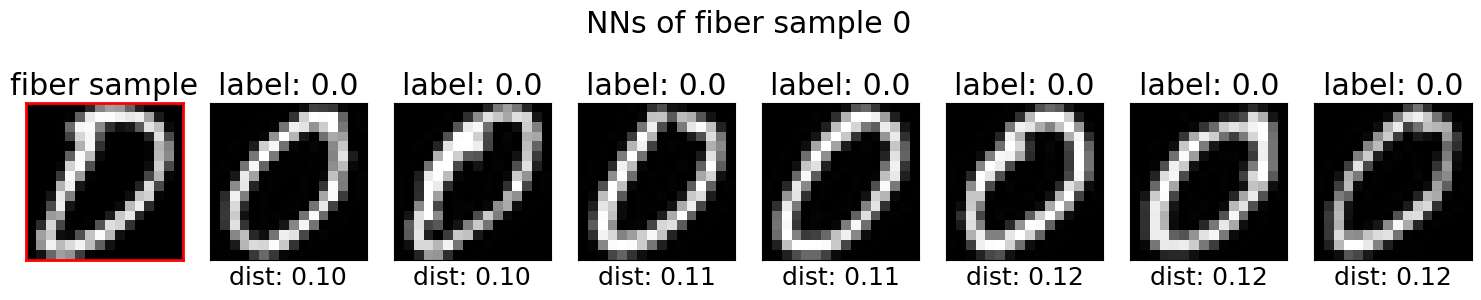

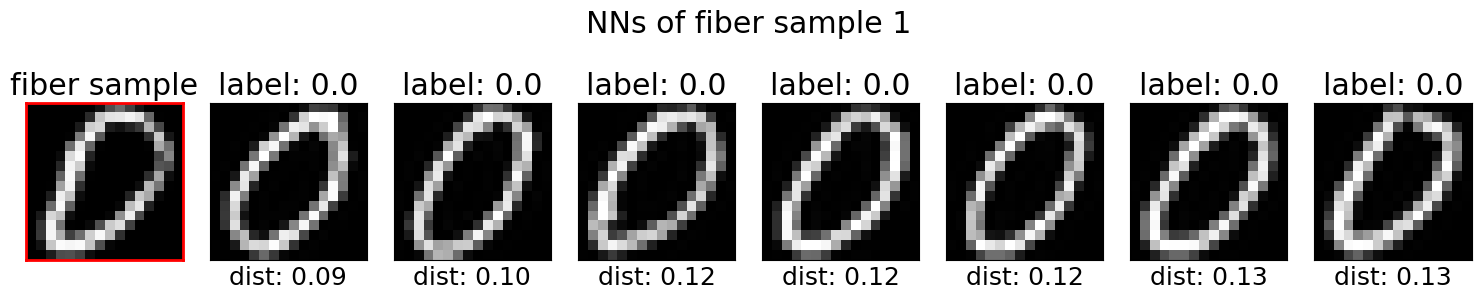

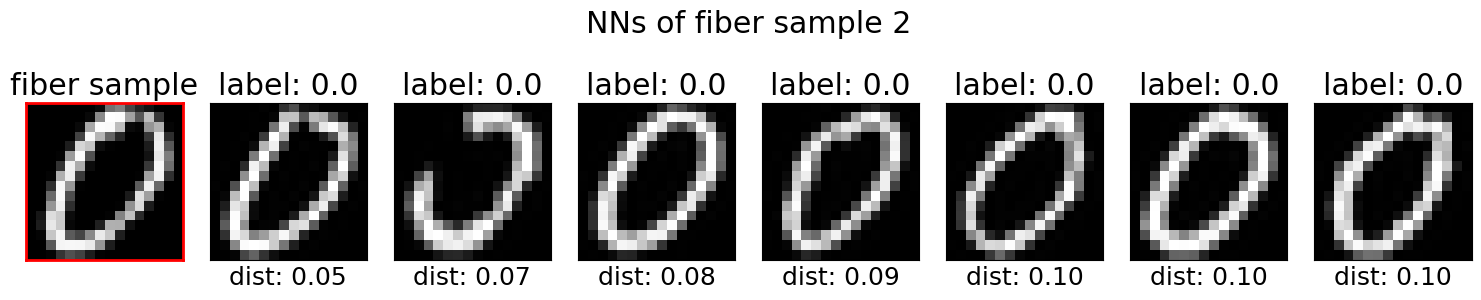

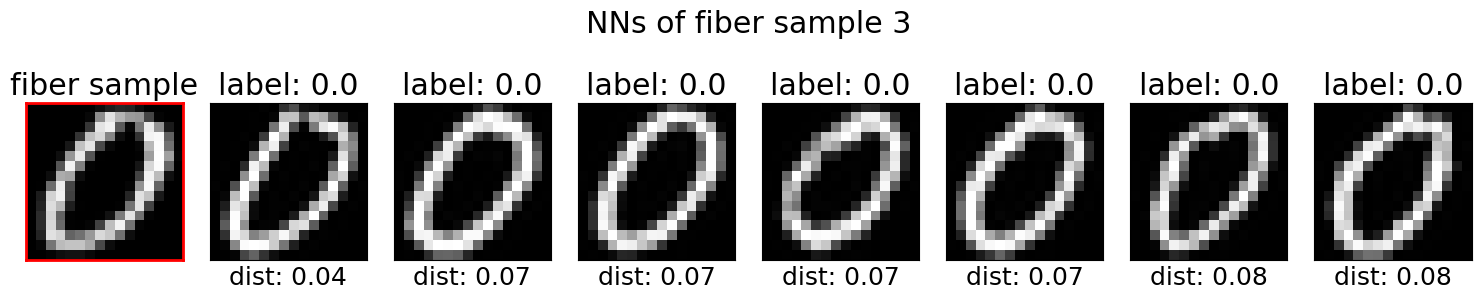

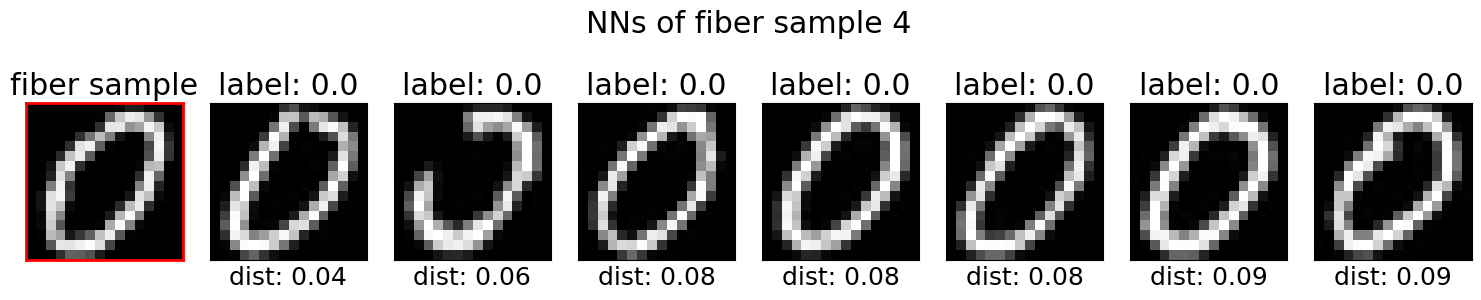

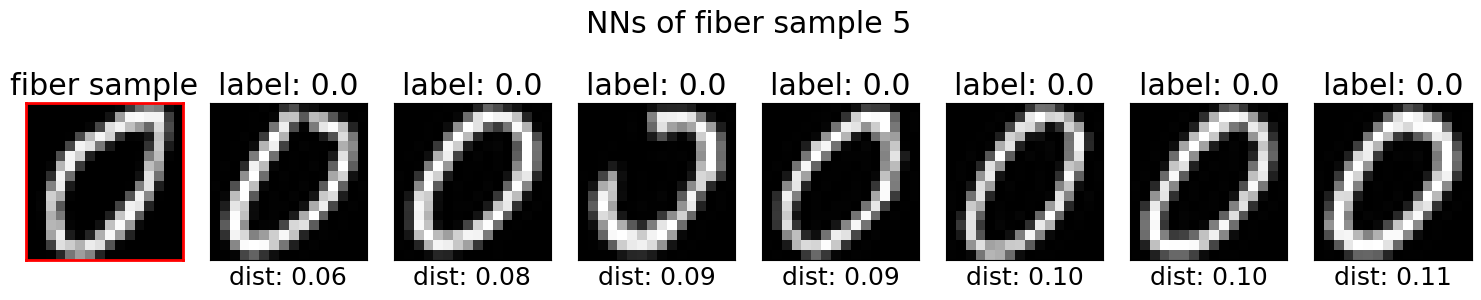

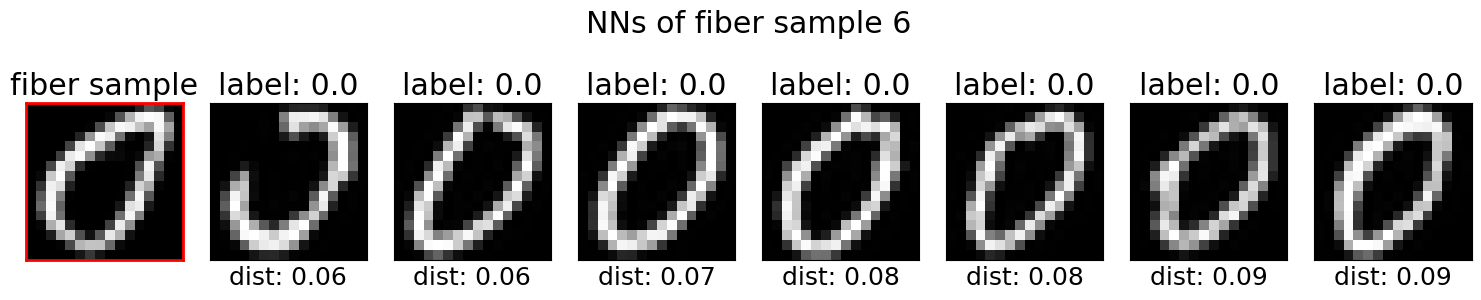

In [30]:
zrange = 4 *std_z0
nums = [0,9,7,9,2,2,3,1,0,0,6,4,9,3,8,2,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5]
ran = [35,0,12,2,5,6,7,10,11,14]
ran = [0]

for j in ran:
    plot_details(model, data, j, zrange, GD_steps=20, sanity=False)